# Folding simulations of FoxP1 - Production

### Introduction

This tutorial aims at running and analyzing equilibrium folding simulations for a small protein. Our protein will be the DNA binding domain of the forkhead box P1 (a.k.a. FoxP1) transcription factor protein. The tutorial will be divided into two parts: Production and analysis. 

The first part is the folding simulation data production, which will be addressed in this notebook. The analysis part is in the second notebook:

[02-Analysis Notebook](02-Analysis.ipynb)

We will need two files to sample the folding, conformational landscape using Structure-Based Models (SBMs). The protein structure and the contact file. Both are provided here in the input notebook. For further details on how to get these files, please refer to our basic tutorials:

[Basic tutorials](https://github.com/CompBiochBiophLab/sbm-openmm/tree/master/tutorials/basic)

We start by importing the necessary libraries.

In [1]:
import sbmOpenMM
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

Using the contact and input file, we create an All-atom SBM model (AA-SBM).

In [2]:
pdb_file = 'input/FoxP_monomer.pdb'
contact_file = 'input/FoxP_monomer.contacts'

sbmAA = sbmOpenMM.models.getAllAtomModel(pdb_file, contact_file)

Generating AA SBM for structure file input/FoxP_monomer.pdb

Setting up geometrical parameters:
_________________________________
Removing hydrogens from topology
Added 747 atoms
Added 767 bonds
Added 1038 angles
Added 855 torsions
Added 166 impropers
Added 357 planars
Reading contacts from contact file: input/FoxP_monomer.contacts
Added 822 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
grouping torsions in backbone and side-chain groups:
Adding default torsion parameters:
Adding default improper parameters:
Adding default planar parameters:
Adding default contact parameters:
Adding default excluded volume parameters:

Adding Forces:
_____________
Adding Harmonic Bond Forces
Adding Harmonic Angle Forces
Adding Periodic Torsion Forces
Adding Harmonic Improper Forces
Adding Periodic Planar Forces
Adding Lennard Jones 12-6 Forces to native contacts
Adding Lennard Jones 12

We next set up the OpenMM integrator and simulation. As before, we give them the topology, system, and positions directly from our sbmAA object. We will select the folding temperature as our integrator temperature. To estimate this parameter, please refer to the "basic" tutorial notebook on this subject:

[Tutorial on folding temperature](https://github.com/CompBiochBiophLab/sbm-openmm/blob/master/tutorials/basic/03-FoldingTemperature/foldingTemperature.ipynb)

Note that temperature is given as kelvin; however, this is only to keep consistency with OpenMM's units. Since our simulation is a simplified forcefield and has not been calibrated to match any unit system, we will refer to the temperature units as reduced temperature units (RTU). 

In [3]:
temperature = 105.35 # Folding temperature for the FoxP1 system using the AA-SBM.
integrator = LangevinIntegrator(temperature*kelvin, 1.0/picosecond, 0.002*picoseconds)
simulation = Simulation(sbmAA.topology, sbmAA.system, integrator)
simulation.context.setPositions(sbmAA.positions)

Additionally, we would like to report energies and trajectory data into files. For this, we set up a DCDReporter (trajectory in DCD format) and a special StateDataReporter included inside the sbmOpenMM library. If we pass the sbmAA to the reporter with the option sbmObject, it will automatically report all the SBM energies. Since we are interested only in the trajectory information for the analysis, we will print the energies in this notebook only to observe the simulation's progression.

In [4]:
# Import stdout to print simulation output in the notebook
from sys import stdout

In [5]:
# Define report frequency
report_frequency = 1 # in ns
print_report_frequency = 20 # in ns
time_step = 0.002 # in ps
report_steps = int(report_frequency*1000/time_step)
print_report_steps = int(print_report_frequency*1000/time_step)

# Add trajectory reporter
simulation.reporters.append(DCDReporter('output/FoxP1_folding_traj.dcd', report_steps))

# Add energy reporter
sbmReporter = sbmOpenMM.reporter.sbmReporter(stdout, print_report_steps, 
                                             step=True, potentialEnergy=True, 
                                             temperature=True, sbmObject=sbmAA)
simulation.reporters.append(sbmReporter)

To run the simulation, we should define the time-length of our folding simulation. The simulation should be long enough to observe several transitions of our process, such we can explore the least probable regions (a.k.a. transition-state region) of the FoxP1 folding process. In the publication presenting the SBMOpenMM library ([Link to our article]()) we ran 15 replicas of 10$\mu{s}$ each. Here we will run a small trajectory to check that the simulation's behavior is correct. However, it is recommended to set a python script to make the full production runs.

We estimated that the mean first passage time of the FoxP1 AA-SBM system is about 0.5 $\mu s$. Therefore, to observe (un)folding transitions, we will run a trajectory of 10 $\mu s$, storing data every one ns. Note that this can take several days on a computer with a GPU card.

In [6]:
simulation_time = 10 # in microseconds
simulation_steps = int(simulation_time*10**6/time_step)
simulation.step(simulation_steps)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Harmonic Bond Energy (kJ/mol)","Harmonic Angle Energy (kJ/mol)","Periodic Torsion Energy (kJ/mol)","Harmonic Improper Energy (kJ/mol)","Harmonic Planar Energy (kJ/mol)","LJ 12-6 Contact Energy (kJ/mol)","LJ 12 Repulsion Energy (kJ/mol)"
10000000,668.9398193359375,102.25201721455743,335.5773620605469,328.16668701171875,141.7840576171875,32.031341552734375,81.90013885498047,-268.4825744628906,17.96278190612793
20000000,680.4814453125,102.662806414236,350.0411682128906,346.1851806640625,130.75808715820312,37.609779357910156,71.37718200683594,-271.201904296875,15.711991310119629
30000000,658.8499755859375,103.27246019859194,329.60296630859375,334.58880615234375,131.14231872558594,35.83778762817383,86.46461486816406,-272.37872314453125,13.592233657836914
40000000,690.5955200195312,100.68987190614723,356.7434997558594,353.34881591796875,135.63438415527344,35.98560333251953,88.03089141845703,-291.3752746582031,12.227592468261719
50000000

470000000,656.5198974609375,110.27460587603466,361.86883544921875,320.19915771484375,126.76763916015625,37.16187286376953,86.56147766113281,-290.0724182128906,14.033332824707031
480000000,660.1114501953125,103.2666834327151,368.93792724609375,316.8692626953125,145.79150390625,37.16810607910156,72.36727142333984,-293.8521423339844,12.829527854919434
490000000,616.6260986328125,105.77339063520351,302.74908447265625,328.45294189453125,150.65231323242188,34.27594757080078,79.21085357666016,-295.8312683105469,17.116172790527344
500000000,640.8350830078125,106.50771923292461,332.15423583984375,329.0346374511719,132.29147338867188,35.563087463378906,81.22355651855469,-286.1441955566406,16.712329864501953
510000000,633.6559448242188,105.1005071345246,307.468994140625,369.9233703613281,122.74978637695312,34.17499923706055,78.42543029785156,-292.09869384765625,13.012084007263184
520000000,669.73388671875,102.32061805280075,303.16461181640625,368.45452880859375,132.40988159179688,34.7733955383300

940000000,658.2681884765625,103.8135994482508,327.913818359375,355.50286865234375,131.3441925048828,32.53804016113281,79.34336853027344,-280.5866394042969,12.212618827819824
950000000,707.6966552734375,108.99483366684555,350.95050048828125,340.2152099609375,138.4461669921875,37.02560806274414,90.74079895019531,-264.395751953125,14.714188575744629
960000000,654.642333984375,100.44185944604011,336.7111511230469,341.37176513671875,131.67230224609375,44.766761779785156,87.53289031982422,-304.30316162109375,16.89055633544922
970000000,693.8561401367188,109.23432359971677,326.2510070800781,372.2860412597656,136.37078857421875,29.07870101928711,83.93449401855469,-268.3418273925781,14.276926040649414
980000000,710.1942138671875,101.12301807211016,380.04229736328125,341.86785888671875,122.14642333984375,36.48672103881836,80.49601745605469,-265.5356750488281,14.690610885620117
990000000,704.663330078125,108.06172650733794,333.69024658203125,331.5130920410156,141.17095947265625,35.35456085205078,

1410000000,659.21337890625,97.64018626707083,322.3966979980469,371.1575012207031,129.92520141601562,26.11980438232422,87.18586730957031,-285.46929931640625,7.897574424743652
1420000000,662.5864868164062,102.89456821123224,310.384765625,356.9593505859375,135.59732055664062,35.29688262939453,90.38131713867188,-279.290283203125,13.257160186767578
1430000000,708.9271240234375,105.11939701727316,364.01220703125,384.01580810546875,119.896240234375,28.338924407958984,82.71542358398438,-286.43719482421875,16.385719299316406
1440000000,606.954833984375,100.1691792792394,319.6800842285156,343.9180908203125,116.07968139648438,30.12155532836914,86.49720001220703,-302.717041015625,13.3753023147583
1450000000,693.9446411132812,106.90897916111719,362.937744140625,344.7049865722656,134.3835906982422,33.321434020996094,86.75151824951172,-278.79046630859375,10.635880470275879
1460000000,711.3770141601562,106.10140696491021,337.09564208984375,368.3304443359375,141.1234893798828,32.76161575317383,87.63536

1880000000,549.5734252929688,101.51181794727619,311.66644287109375,321.7181396484375,115.43809509277344,32.54901885986328,72.640625,-318.134521484375,13.695634841918945
1890000000,641.268798828125,113.55294534064474,356.4764709472656,306.49200439453125,134.53529357910156,26.315467834472656,83.07768249511719,-278.8062744140625,13.178144454956055
1900000000,720.7368774414062,107.86798207001598,335.36920166015625,371.13128662109375,134.236083984375,32.57013702392578,90.84490966796875,-260.584716796875,17.169963836669922
1910000000,676.8336791992188,102.94841717368526,358.1497497558594,368.55889892578125,117.81317138671875,30.120147705078125,83.73420715332031,-293.51898193359375,11.976577758789062
1920000000,590.5379638671875,101.33999028915589,329.43536376953125,308.6487731933594,126.77774810791016,33.985408782958984,80.97697448730469,-299.73577880859375,10.449501991271973
1930000000,705.77001953125,108.76145291017889,364.55059814453125,367.13360595703125,137.7725830078125,30.567825317382

2350000000,669.084716796875,106.84770914068467,335.0850830078125,369.70458984375,127.49359130859375,35.777950286865234,82.65895080566406,-295.0142822265625,13.378860473632812
2360000000,666.5478515625,108.26886538871089,325.28363037109375,357.10308837890625,128.93994140625,34.47721862792969,93.62055969238281,-288.0322265625,15.155619621276855
2370000000,611.4794921875,105.01102241106135,315.1565856933594,331.5456237792969,133.5442657470703,38.96799087524414,85.14547729492188,-306.1040344238281,13.223655700683594
2380000000,660.6951293945312,96.79511847243836,326.722900390625,352.8996887207031,144.76123046875,41.72208023071289,80.05425262451172,-300.54522705078125,15.080225944519043
2390000000,693.833251953125,108.15559148586719,342.54443359375,357.881591796875,126.18914794921875,45.56414794921875,98.28346252441406,-289.48638916015625,12.856815338134766
2400000000,649.1461181640625,105.70927375420514,323.99517822265625,336.8310852050781,135.32772827148438,26.61105728149414,78.9439392089

KeyboardInterrupt: 

We will use mdtraj to visualize the progression of the trajectory. We will plot the radius of gyration to see the folded and unfolded states of the system clearly.

In [7]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Define input for analysis
topology = 'input/FoxP_monomer.pdb'
trajectory_file = 'output/FoxP1_folding_traj.dcd'

# Load trajectory into MDtraj
traj = md.load(trajectory_file, top=topology)

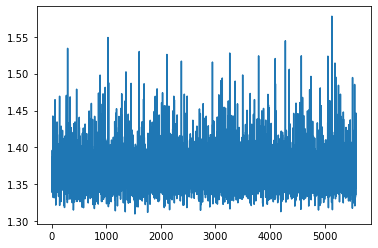

In [9]:
rg = md.compute_rg(traj) # Calculate the radius of gyration for the trajectory
time = np.array(range(1, traj.n_frames+1))*report_frequency
plt.plot(time, rg)

We observe...